**PROBLEM STATEMENT**: What we are really trying to figure out with this analysis is the location of Chineses restaurants in the city of New York in order to subtract conclusions about where to open our Chinese restaurant.

First, we import the libraries that we need

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
!pip install folium

import os
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 94 kB 5.8 MB/s  eta 0:00:01
Libraries imported.


In the **FIRST PART**, we will extract data from the city of New York: boroughs, neighborhoods, population..., all obtained from Wikipedia.

In [51]:
response_obj = requests.get('https://en.wikipedia.org/wiki/New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Neighborhoods_NYC_Table = soup.find('table', {'class':'wikitable sortable'})

In [57]:
rows = Neighborhoods_NYC_Table.select("tbody > tr")[3:8]

boroughs = []
for row in rows:
    borough = {}
    tds = row.select('td')
    borough["Borough"] = tds[0].text.strip()
    borough["County"] = tds[1].text.strip()
    borough["Population"] = float(tds[2].text.strip().replace(",",""))
    borough["GDP (billions)"] = float(tds[3].text.strip().replace(",",""))
    borough["land_sqm"] = float(tds[4].text.strip().replace(",",""))
    borough["land_sqkm"] = float(tds[5].text.strip().replace(",",""))
    borough["persons_sqm"] = float(tds[6].text.strip().replace(",",""))
    borough["persons_sqkm"] = float(tds[7].text.strip().replace(",",""))
    
    boroughs.append(borough)

print(boroughs)

[{'borough': 'The Bronx', 'county': 'Bronx', 'population': 1418207.0, 'gdp_billions': 42.695, 'land_sqm': 42.1, 'land_sqkm': 109.04, 'persons_sqm': 33867.0, 'persons_sqkm': 13006.0}, {'borough': 'Brooklyn', 'county': 'Kings', 'population': 2559903.0, 'gdp_billions': 91.559, 'land_sqm': 70.82, 'land_sqkm': 183.42, 'persons_sqm': 36147.0, 'persons_sqkm': 13957.0}, {'borough': 'Manhattan', 'county': 'New York', 'population': 1628706.0, 'gdp_billions': 600.244, 'land_sqm': 22.83, 'land_sqkm': 59.13, 'persons_sqm': 71341.0, 'persons_sqkm': 27544.0}, {'borough': 'Queens', 'county': 'Queens', 'population': 2253858.0, 'gdp_billions': 93.31, 'land_sqm': 108.53, 'land_sqkm': 281.09, 'persons_sqm': 20767.0, 'persons_sqkm': 8018.0}, {'borough': 'Staten Island', 'county': 'Richmond', 'population': 476143.0, 'gdp_billions': 14.514, 'land_sqm': 58.37, 'land_sqkm': 151.18, 'persons_sqm': 8157.0, 'persons_sqkm': 3150.0}]


In [62]:
df = pd.DataFrame(boroughs, columns=["borough","county", "population", "gdp_billions", "land_sqm","land_sqkm","persons_sqm","persons_sqkm"]) 
df

,borough,county,population,gdp_billions,land_sqm,land_sqkm,persons_sqm,persons_sqkm
0,The Bronx,Bronx,1418207.0,42.695,42.10,109.04,33867.0,13006.0
1,Brooklyn,Kings,2559903.0,91.559,70.82,183.42,36147.0,13957.0
2,Manhattan,New York,1628706.0,600.244,22.83,59.13,71341.0,27544.0
3,Queens,Queens,2253858.0,93.310,108.53,281.09,20767.0,8018.0
4,Staten Island,Richmond,476143.0,14.514,58.37,151.18,8157.0,3150.0


Brooklyn is the most populous borough, but when it comes to the density, Manhattan is the borough this the highest one. In both cases, Staten Island remains as the least populous and least dense borough.

Even though this is a globalized and multicultural world and Chinese food attracts people from different cultural, social and economic backgrounds, it is true that Chinese food is consumed the most by Chinese people. Wikipedia will let us see distribution by races, and we will take Asian ethnicity as a reference even though it would be pretty inaccurate. 


In [75]:
response_obj = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Population_Census_Table = soup.select_one('.wikitable:nth-of-type(5)') #use css selector to target correct table.

jurisdictions = []
rows = Population_Census_Table.select("tbody > tr")[2:8]
for row in rows:
    jurisdiction = {}
    tds = row.select('td')
    jurisdiction["Jurisdiction"] = tds[0].text.strip()
    jurisdiction["Population_census"] = tds[1].text.strip()
    jurisdiction["% White"] = float(tds[2].text.strip().replace(",",""))
    jurisdiction["% Black or African American"] = float(tds[3].text.strip().replace(",",""))
    jurisdiction["% Asian"] = float(tds[4].text.strip().replace(",",""))
    jurisdiction["% Other"] = float(tds[5].text.strip().replace(",",""))
    jurisdiction["% Mixed Race"] = float(tds[6].text.strip().replace(",",""))
    jurisdiction["% Hispanic latino of other race"] = float(tds[7].text.strip().replace(",",""))
    jurisdictions.append(jurisdiction)

print(jurisdictions)

[{'Jurisdiction': 'Brooklyn', 'Population_census': '2,465,326', '% White': 41.2, '% Black or African American': 36.4, '% Asian': 7.5, '% Other': 10.6, '% Mixed Race': 4.3, '% Hispanic latino of other race': 19.8}, {'Jurisdiction': 'Queens', 'Population_census': '2,229,379', '% White': 44.1, '% Black or African American': 20.0, '% Asian': 17.6, '% Other': 12.3, '% Mixed Race': 6.1, '% Hispanic latino of other race': 25.0}, {'Jurisdiction': 'Manhattan', 'Population_census': '1,537,195', '% White': 54.4, '% Black or African American': 17.4, '% Asian': 9.4, '% Other': 14.7, '% Mixed Race': 4.1, '% Hispanic latino of other race': 27.2}, {'Jurisdiction': 'Bronx', 'Population_census': '1,332,650', '% White': 29.9, '% Black or African American': 35.6, '% Asian': 3.0, '% Other': 25.7, '% Mixed Race': 5.8, '% Hispanic latino of other race': 48.4}, {'Jurisdiction': 'Staten Island', 'Population_census': '443,728', '% White': 77.6, '% Black or African American': 9.7, '% Asian': 5.7, '% Other': 4.3,

In [76]:
df = pd.DataFrame(jurisdictions, columns=["Jurisdiction","% White", "% Black or African American", "% Asian", "% Other", "% Mixed Race", "% Hispanic latino of other race"])
df

,Jurisdiction,% White,% Black or African American,% Asian,% Other,% Mixed Race,% Hispanic latino of other race
0,Brooklyn,41.2,36.4,7.5,10.6,4.3,19.8
1,Queens,44.1,20.0,17.6,12.3,6.1,25.0
2,Manhattan,54.4,17.4,9.4,14.7,4.1,27.2
3,Bronx,29.9,35.6,3.0,25.7,5.8,48.4
4,Staten Island,77.6,9.7,5.7,4.3,2.7,12.1
5,NYC Total,44.7,26.6,9.8,14.0,4.9,27.0


As a conclusion, we can see that Asian population has a higher Asian population (in % of total population) in Queens.

Now we are going to use FourSquare API to combine it with the New York data that we have to deine the boroughs and neighborhoods, as well as their coordinates.

In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    radius=1000 #NOTE: we are computing a radius of 1,000 metres for a given latitude and longitude.
    LIMIT=100 
    CLIENT_ID = '2H4RR242WMLP4G3EVWS15MS2AYOFZUCGAZC0HVHDZSISLU01' 
    CLIENT_SECRET ='DMMYS1UIV4PIVSUROY3XOR2KYOBRNVMZDKL10CL5SZWOPIIR' 
    VERSION = '20210208'
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
 
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '2H4RR242WMLP4G3EVWS15MS2AYOFZUCGAZC0HVHDZSISLU01'
    CLIENT_SECRET ='DMMYS1UIV4PIVSUROY3XOR2KYOBRNVMZDKL10CL5SZWOPIIR' 
    VERSION = '20210208' 
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] #NOTE: we are defininf the colums for the dataframe we want to creat
    new_york_data = pd.DataFrame(columns=column_names) #NOTE 2: we are re-naming the dataframe to new_york_data
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.shape

(306, 4)

**WE CAN SEE THAT THE CITY OF NEW YORK IS COMPOSED BY 5 MAIN AND WELL KNOWN BOROUGHS AND THEY ARE DIVIDED IN 306 DIFFERENT NEIGHBORHOODS**. Some of them are more famous and notorious than others (for example, Upper East Side)

Out of curiosity, we want to check what boroughs have more neighborhoods.

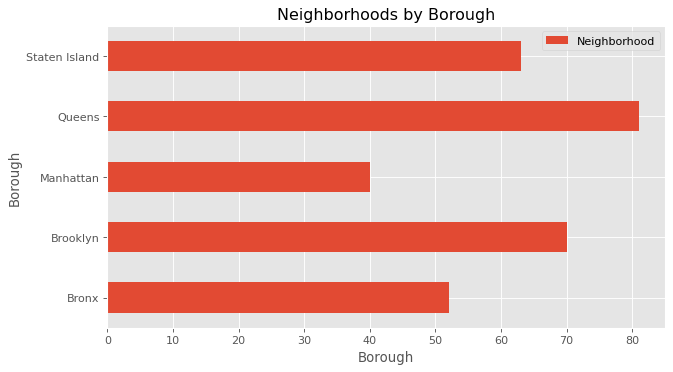

In [8]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
plt.title('Neighborhoods by Borough') #Title of the chart
plt.xlabel('Borough', fontsize = 12) #X-axis, the name of the borough
plt.ylabel('No.of Neighborhood', fontsize=12) #Y-axis, number of neighborhoods
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='barh')

plt.legend()
plt.show()

We can see that Queens is the borough comoposed by the highest number of neighborhoods.

**PART 2: NOW IT IS TIME TO GAIN KNOWLEDGE ABOUT CHINESE RESTAURANTS** - we are going to crave Foursquare a neighborhood list that contains chinese restaurants in NY.

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:1
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:1
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:2
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:3
( 10 / 306 ) Chinese Restaurants in Williamsbridge, Bronx:2
( 11 / 306 ) Chinese Restaurants in Baychester, Bronx:2
( 12 / 306 ) Chinese Restaurants in Pelham Parkway, Bronx:3
( 13 / 306 ) Chinese Restaurants in City Island, Bronx:1
( 14 / 306 ) Chinese Restaurants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Restaurants in University Heights, Bronx:1
( 16 / 306 ) Chinese Restaurants in Morris Heights, Bronx:2
( 17 / 306 ) Chinese Restaurants in Fordham, Bronx:1
( 18 / 306 ) Chinese Restaurants in Ea

( 138 / 306 ) Chinese Restaurants in Richmond Hill, Queens:2
( 139 / 306 ) Chinese Restaurants in Flushing, Queens:14
( 140 / 306 ) Chinese Restaurants in Long Island City, Queens:0
( 141 / 306 ) Chinese Restaurants in Sunnyside, Queens:4
( 142 / 306 ) Chinese Restaurants in East Elmhurst, Queens:1
( 143 / 306 ) Chinese Restaurants in Maspeth, Queens:2
( 144 / 306 ) Chinese Restaurants in Ridgewood, Queens:2
( 145 / 306 ) Chinese Restaurants in Glendale, Queens:1
( 146 / 306 ) Chinese Restaurants in Rego Park, Queens:3
( 147 / 306 ) Chinese Restaurants in Woodhaven, Queens:3
( 148 / 306 ) Chinese Restaurants in Ozone Park, Queens:1
( 149 / 306 ) Chinese Restaurants in South Ozone Park, Queens:1
( 150 / 306 ) Chinese Restaurants in College Point, Queens:2
( 151 / 306 ) Chinese Restaurants in Whitestone, Queens:2
( 152 / 306 ) Chinese Restaurants in Bayside, Queens:2
( 153 / 306 ) Chinese Restaurants in Auburndale, Queens:3
( 154 / 306 ) Chinese Restaurants in Little Neck, Queens:5
( 155

( 271 / 306 ) Chinese Restaurants in Mount Hope, Bronx:1
( 272 / 306 ) Chinese Restaurants in Sutton Place, Manhattan:1
( 273 / 306 ) Chinese Restaurants in Hunters Point, Queens:0
( 274 / 306 ) Chinese Restaurants in Turtle Bay, Manhattan:0
( 275 / 306 ) Chinese Restaurants in Tudor City, Manhattan:0
( 276 / 306 ) Chinese Restaurants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Chinese Restaurants in Flatiron, Manhattan:2
( 278 / 306 ) Chinese Restaurants in Sunnyside Gardens, Queens:1
( 279 / 306 ) Chinese Restaurants in Blissville, Queens:4
( 280 / 306 ) Chinese Restaurants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Chinese Restaurants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Chinese Restaurants in Weeksville, Brooklyn:5
( 283 / 306 ) Chinese Restaurants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Chinese Restaurants in Dumbo, Brooklyn:0
( 285 / 306 ) Chinese Restaurants in Manor Heights, Staten Island:4
( 286 / 306 ) Chinese Restaurants in Willowbrook, Staten Island:3
( 287 / 3

In [11]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4e2710b7a809510950dd6b32,Double Dragon
1,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
2,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
3,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
4,Manhattan,Marble Hill,4bcbae5d68f976b01da46183,Ming Moon Buffet


In [12]:
chinese_rest_ny.shape  #just to confirm the number of Chinese restaurants 

(424, 4)

We can see that there are 424 (!!) Chinese restaurants detected by Foursquare.

As we did before with plotting neighborhoods by borough, now we are going to plot Chinese restaurants by boroughs.

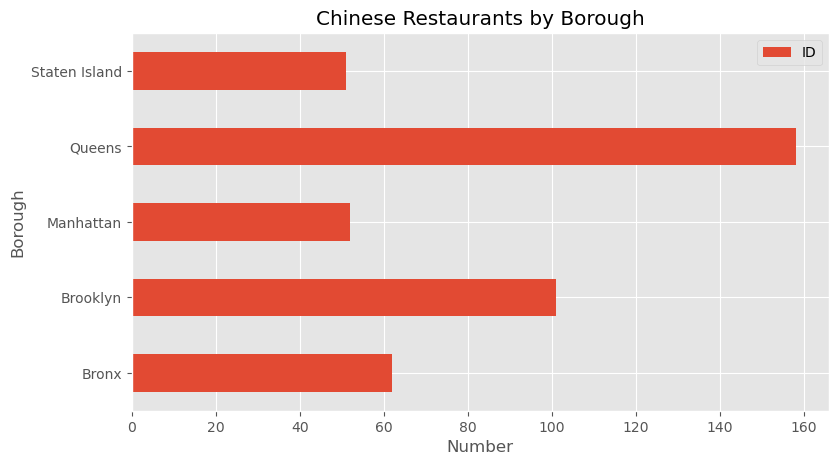

In [15]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Chinese Restaurants by Borough')
plt.xlabel('Number', fontsize = 12)
plt.ylabel('Borough', fontsize=12)

chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='barh')

plt.legend()
plt.show()

In [16]:
chinese_rest_ny.groupby('Borough')['ID'].count()

Borough
Bronx             62
Brooklyn         101
Manhattan         52
Queens           158
Staten Island     51
Name: ID, dtype: int64

Once again, Queens is the absolute leader. When it comes to the total amount of NY Chineses restaurants, 158 of them (almost 38% of the total) are located in the Queens borough.

**WHAT ARE THE NEIGHBORHOODS WITH THE HIGHEST NUMBER OF CHINESE RESTAURANTS??**

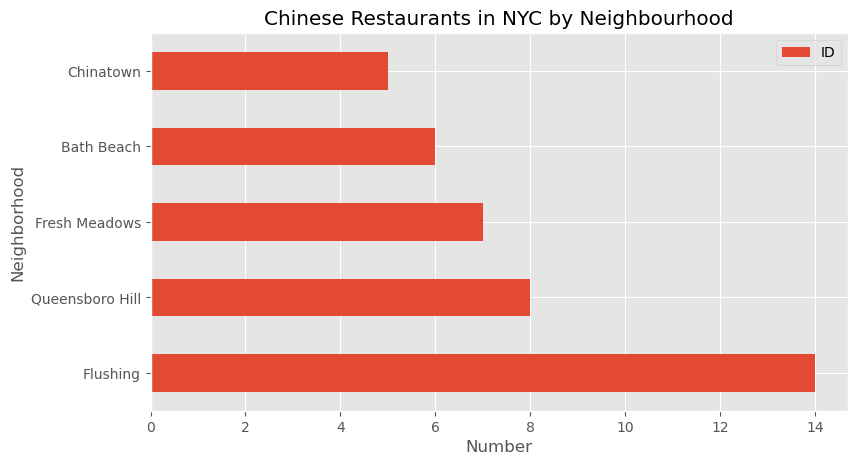

In [19]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Chinese Restaurants in NYC by Neighbourhood')
plt.xlabel('Number', fontsize = 12)
plt.ylabel('Neighborhood', fontsize=12)

chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='barh')

plt.legend()
plt.show()

In [20]:
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10)

Neighborhood
Flushing           14
Queensboro Hill     8
Fresh Meadows       7
Bath Beach          6
Chinatown           5
Little Neck         5
Sunset Park         5
Utopia              5
Weeksville          5
Bellaire            4
Name: ID, dtype: int64

From the Top 10 results, we can see that **Flushing neighborhood** is the home to the highest number of Chinese restaurants.

In [44]:
highest=chinese_rest_ny.groupby('Neighborhood')['ID'].count()>=5
highest

Neighborhood
Allerton                     False
Arden Heights                False
Arrochar                     False
Astoria Heights              False
Auburndale                   False
Bath Beach                    True
Bay Ridge                    False
Bay Terrace                  False
Baychester                   False
Bayside                      False
Bayswater                    False
Bedford Park                 False
Bedford Stuyvesant           False
Beechhurst                   False
Bellaire                     False
Belle Harbor                 False
Bensonhurst                  False
Blissville                   False
Boerum Hill                  False
Borough Park                 False
Briarwood                    False
Broad Channel                False
Broadway Junction            False
Bronxdale                    False
Brooklyn Heights             False
Bulls Head                   False
Cambria Heights              False
Canarsie                     False
Carnegi

Finally, with this list we can check whether or not the total number of Chineses restaurants is 5 or more.

**CONCLUSIONS** 

- Flushing, Queensboro Hills and Fresh Meadows neighborhoods (all located in Queens) are some of the best neighborhoods for Chinese cuisine.
- When it comes to boroughs, Queens is the absolute leader of Chineses restaurants.
- At the bottom, we can check that Manhattan and Staten Island are not very appealing for the Chinese cuisine.
- As for curiosity, the famous and notorious Chinatown Manhattan is not the neighborhood with the highest number of Chinese restaurants.

So, the final recommendation depends on what strategy the restaurant wants to follow. 
1. If the restaurants wants to simply attract the highest number of clients and competition is not a problem for them: then they should start developing the business in Queens, as it is the second most populous borough, has the highest percentage of Asian population, and the highest number of Chinese restaurants. Flushing, Queensboro Hill, Fresh Meadows or Bath Beach are great neighborhood options to start.
2. However, if the restaurant wants to gain a competitive strategy by being the first-mover or not facing a high rivalry level, Manhattan could be considered as a more than acceptable option: it is the most dense borough, the second with the highest Asian population (%), but at the same time one of the boroughs with the lowest number of Chinese restaurants. The market and demand is there, and competition is low.
3. We would not recommend the restaurant to open in Staten Island, as it is the least populated and least dense borough, has a very low percentage of Asian population, and is the borough with the lowest number of Chinese restaurants for a reason.

